In [1]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import networkx as nx
import gym 
from tqdm import tqdm 
from collections import deque
import seaborn as sns
from src.agents.UCB import UCB
from src.agents.NUCB import NUCB
from src.agents.etc import ExploreThenCommit
from src.environment.env_example import StochasticEnvironmentExample
from src.environment.stochastic_env import StochasticEnvironment
from src.utils.experiment import plot_regret

# Play function

In [3]:
colors = sns.color_palette('colorblind')

def experiment(environment, agents, Nmc, T):
    """
    Run multiple simulations of each agent interacting with the environment and record regret.

    This function evaluates a list of agents by having them interact with a given environment
    over multiple Monte Carlo simulations, each lasting for a fixed time horizon.
    For each agent, it computes and stores the regret over time for each trajectory.

    Parameters
    ----------
    environment : object
        The environment in which the agents operate. 
    
    agents : list
        A list of agent instances. Each agent must implement `reset()`, `get_action()`,
        `receive_reward(action, reward)`, and `name()` methods.
    
    Nmc : int
        Number of Monte Carlo simulations to run for each agent.
    
    T : int
        Time horizon (number of rounds) for each simulation.

    Returns
    -------
    all_data : dict
        A dictionary mapping each agent's name (str) to a NumPy array of shape (Nmc, T),
        containing the regret at each time step for each Monte Carlo run.
    """
    all_data = {}
    best_path, best_reward = environment.get_best_strategy_reward()
    print(f"Best arm is {best_path[-1]}, the optimal path is then {best_path}, and the corresponding reward is {best_reward}")
    for agent in agents:
        # Run Nmc simulations for the current agent and compute regrets
        agent_id, regrets = play(environment, agent, Nmc, T)

        # Store the results in the dictionary under the agent's name
        all_data[agent_id] = regrets

    return all_data

def play(environment, agent, Nmc, T):
    """
    Simulate multiple trajectories of agent-environment interaction and record regret.

    This function simulates the interaction between a single agent and an environment 
    over Nmc independent trajectories, each lasting T rounds. It records the pseudo-regret 
    at each time step by comparing the received reward to the best possible reward.

    Parameters
    ----------
    environment : object
        The environment in which the agent operates. 

    agent : object
        The agent being evaluated. 

    Nmc : int
        Number of Monte Carlo trajectories to simulate.

    T : int
        Time horizon (number of steps per trajectory).

    Returns
    -------
    agent_id : str
        The name or identifier of the agent (via `agent.name()`).

    data : np.ndarray
        A NumPy array of shape (Nmc, T), where each entry contains the pseudo-regret 
        (best possible reward minus received reward) at time t in trajectory n.

    Notes
    -----
    The pseudo-regret at each time step is computed using the current mean rewards
    of the environment arms, which assumes those are fixed and known for evaluation.
    """
    # Initialize the regret matrix
    data = np.zeros((Nmc, T))
    best_path, best_reward = environment.get_best_strategy_reward()
    env = environment
    #print(f"Best arm is {best_path[-1]}, the optimal path is then {best_path}, and the corresponding reward is {best_reward}")
    for episode in tqdm(range(Nmc)):
        env.reset()
        #tree.visualize_tree(t=episode)
        agent.reset()   
        
        for t in range(T):
            if agent.nested():
                path = agent.get_path()  # path of node
                # Get reward for the chosen path and send it back to the agent
                received_reward, path_reward, mean = env.get_reward_by_path(path)
                agent.receive_reward(received_reward, path_reward, path)

            else:
                leaf, index = agent.get_action()
                
                # Get reward for the chosen action and send it back to the agent
                mean = env.get_reward_mu(index)
                received_reward = env.get_reward(index)
                agent.receive_reward(received_reward, index)

            env.step()
            # Compute pseudo-regret: time * best mean - received reward
            data[episode, t] = best_reward - mean
        #print(f"Total reward of {agent.name} at episode {episode} is {agent.total_reward}")
        #print(f"Cumulative Pseudo-Regret of {agent.name()} at episode {episode} is {T * best_reward - agent.total_reward}")
    return agent.name(), data


# First experiments in the basic environment

Var : 1


/Users/a.cablant/Documents/GitHub/CRITEO-INTERNSHIP/src/environment/tree.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


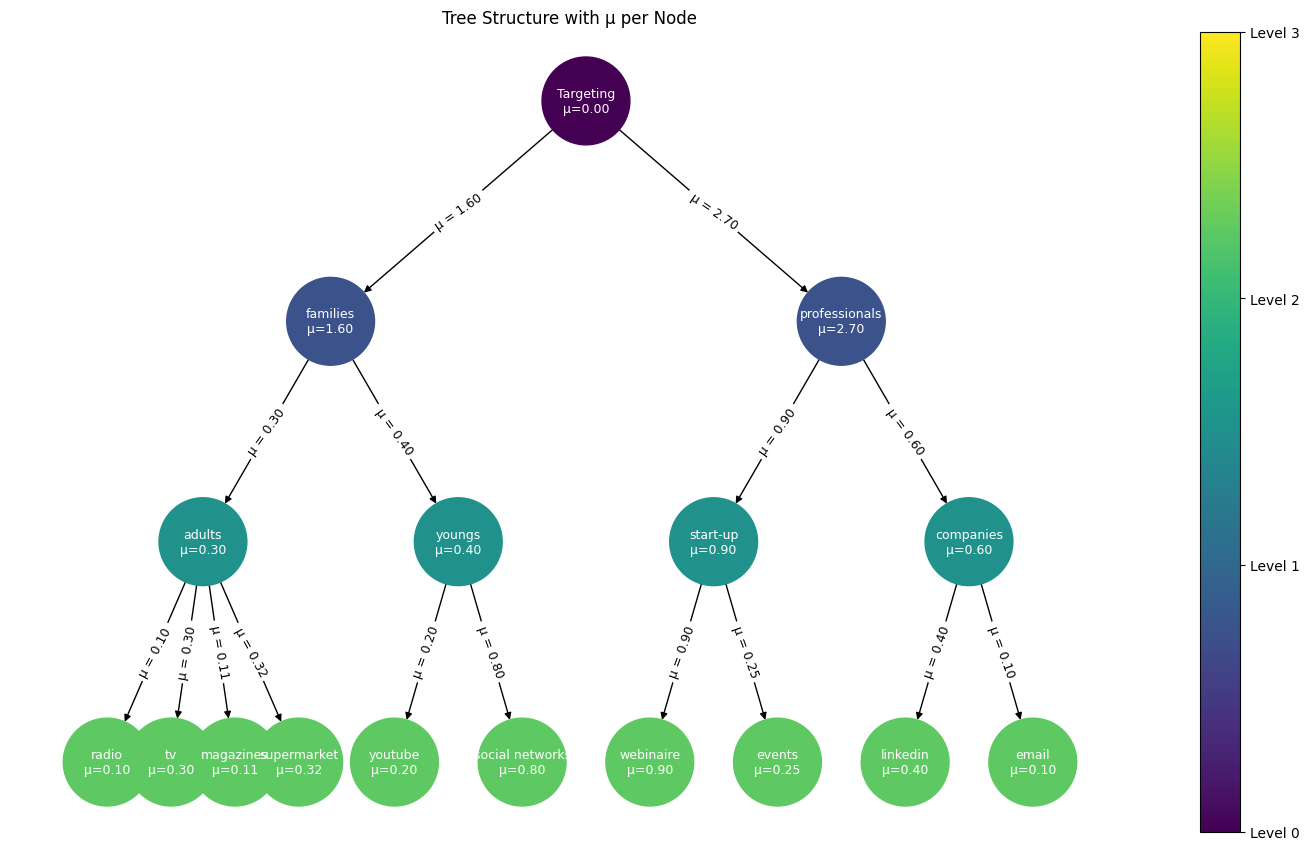

Best arm is webinaire, the optimal path is then ['Targeting', 'professionals', 'start-up', 'webinaire'], and the corresponding reward is 4.5


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]
/Users/a.cablant/Documents/GitHub/CRITEO-INTERNSHIP/src/utils/experiment.py:151: RuntimeWarning: divide by zero encountered in log
  UCB_regret = [np.sqrt(K * t * np.log(t)) for t in time_interval]
/Users/a.cablant/Documents/GitHub/CRITEO-INTERNSHIP/src/utils/experiment.py:151: RuntimeWarning: invalid value encountered in scalar multiply
  UCB_regret = [np.sqrt(K * t * np.log(t)) for t in time_interval]
/Users/a.cablant/Documents/GitHub/CRITEO-INTERNSHIP/src/utils/experiment.py:160: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


Var : 2


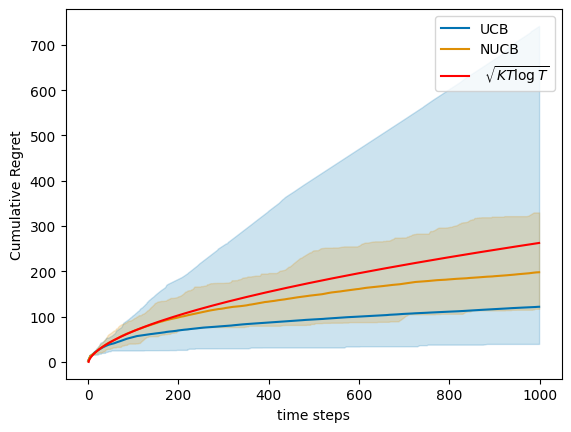

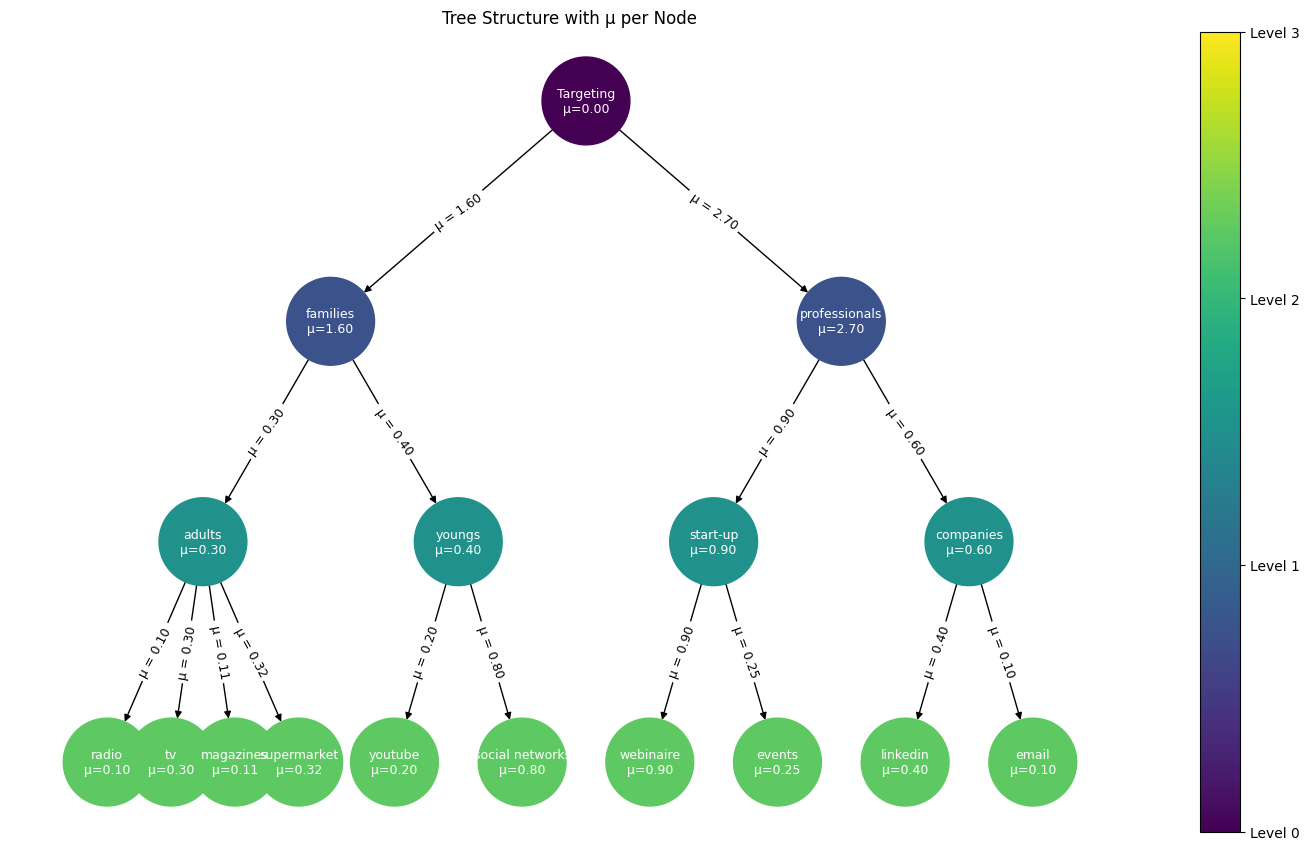

Best arm is webinaire, the optimal path is then ['Targeting', 'professionals', 'start-up', 'webinaire'], and the corresponding reward is 4.5


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Var : 4


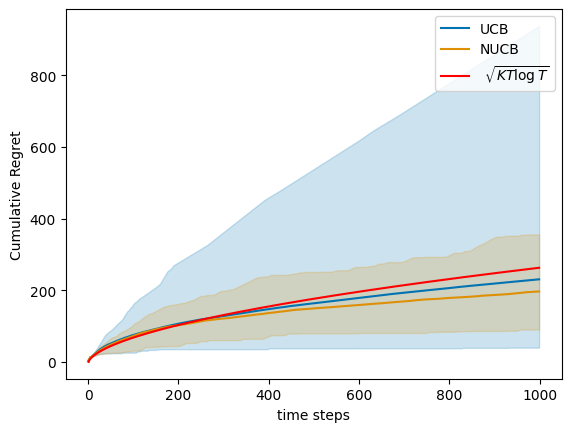

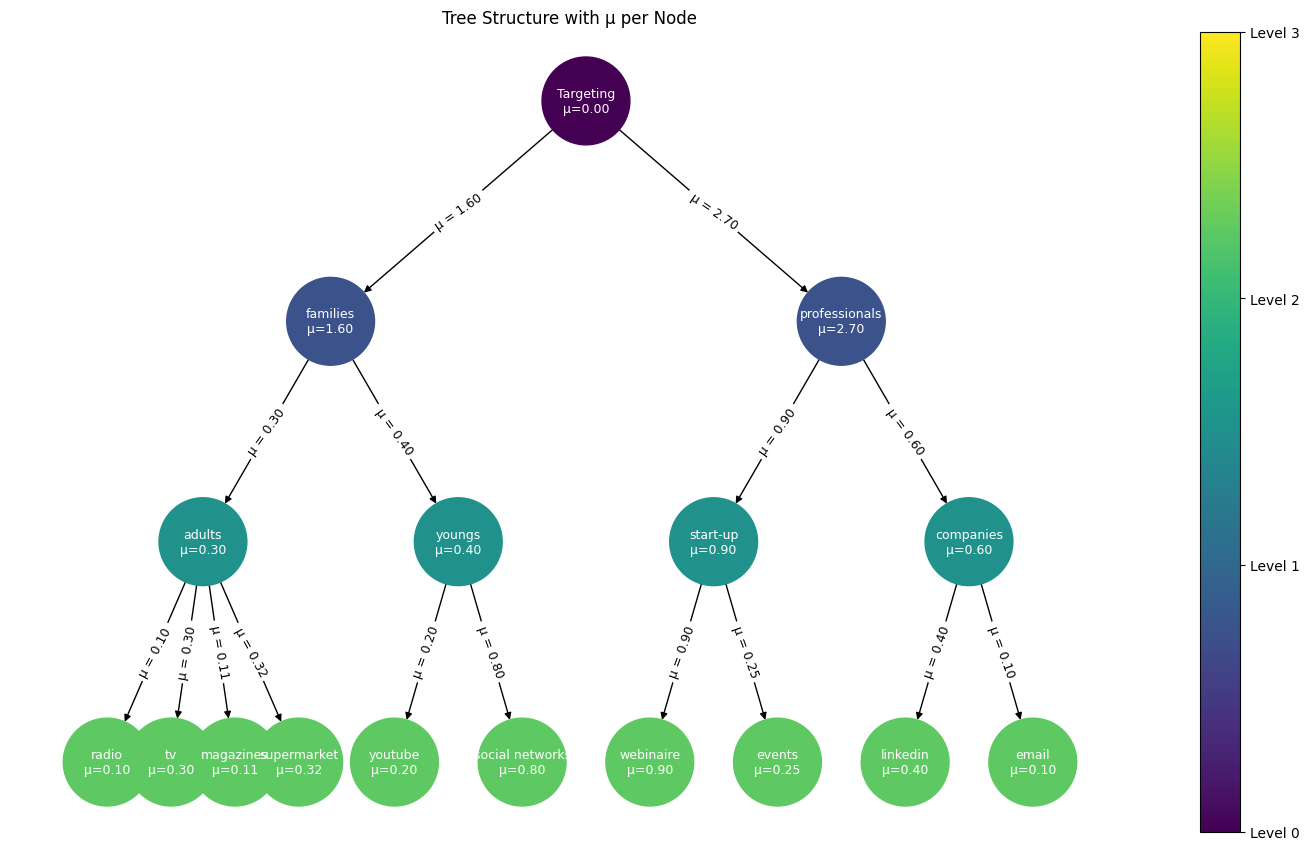

Best arm is webinaire, the optimal path is then ['Targeting', 'professionals', 'start-up', 'webinaire'], and the corresponding reward is 4.5


100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Var : 6


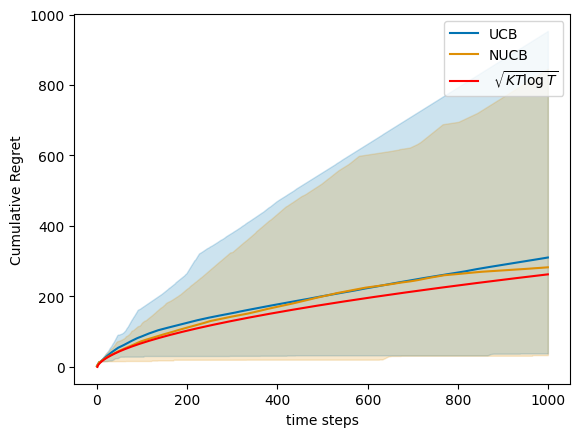

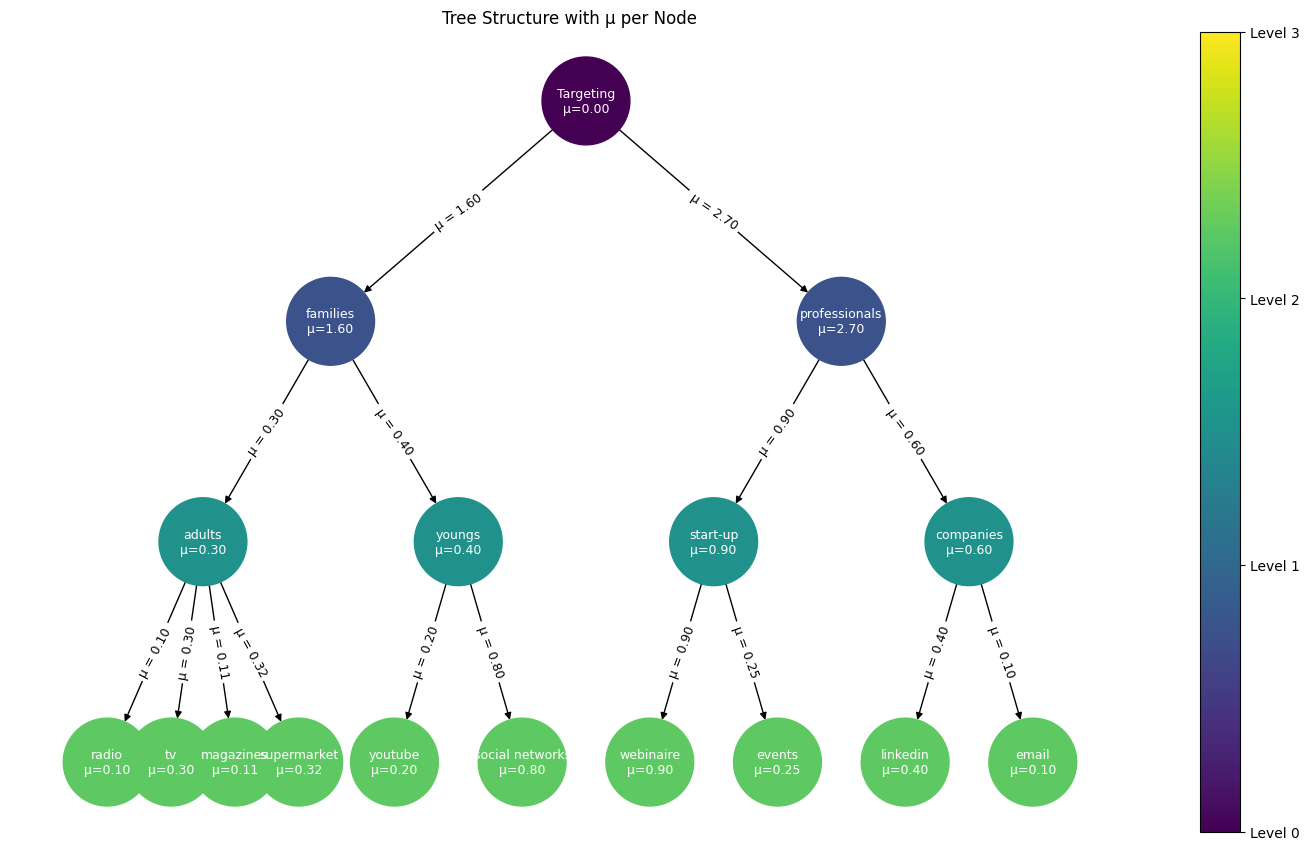

Best arm is webinaire, the optimal path is then ['Targeting', 'professionals', 'start-up', 'webinaire'], and the corresponding reward is 4.5


100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


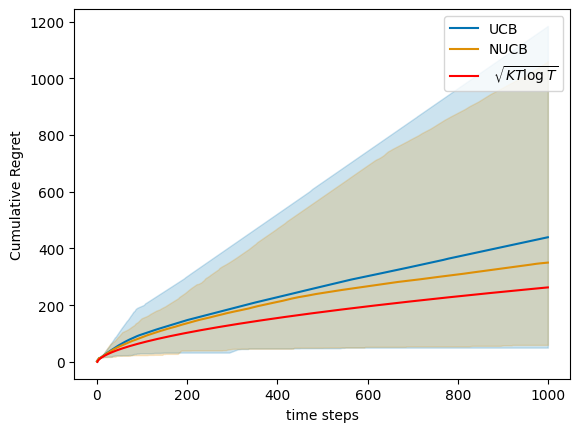

In [3]:
T = 1000  # Finite Horizon
N = 50  # Monte Carlo simulations
q = 10  #choice of percentile display
mus = [0, 
       [1.6, 2.7, 1.5],  # Layer 1
       [[0.3, 0.4], [0.9, 0.6], [0.6, 0.1, 0.4]],  # Layer 2
       [[[0.1, 0.3, 0.11, 0.32], [0.2, 0.8]], [[0.9, 0.25], [0.4, 0.1]], [[0.1, 0.8], [0.3, 0.03], [0.7, 0.01]]] # Layer 3
       ]


for var in [1, 2, 4, 6]:
       print("Var :", var)
       # Framework for the experiments
       env = StochasticEnvironmentExample(mus, var=var)
       env.tree.visualize_tree_mu()
       action_set = env.get_action_set()

       # Initialization of the agents
       ucb = UCB(action_set=action_set)
       nucb = NUCB(tree=env.tree)
       #etc = ExploreThenCommit(action_set=action_set)

       # Run experiments
       all_data = experiment(env, [ucb, nucb], Nmc=N, T=T) # [etc, ucb, nucb]

       # Plot results
       plot_regret(regrets = all_data, logscale = False, lb = None, q = 0.5, UCB_regret=True)

/Users/a.cablant/Documents/GitHub/CRITEO-INTERNSHIP/src/environment/tree.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


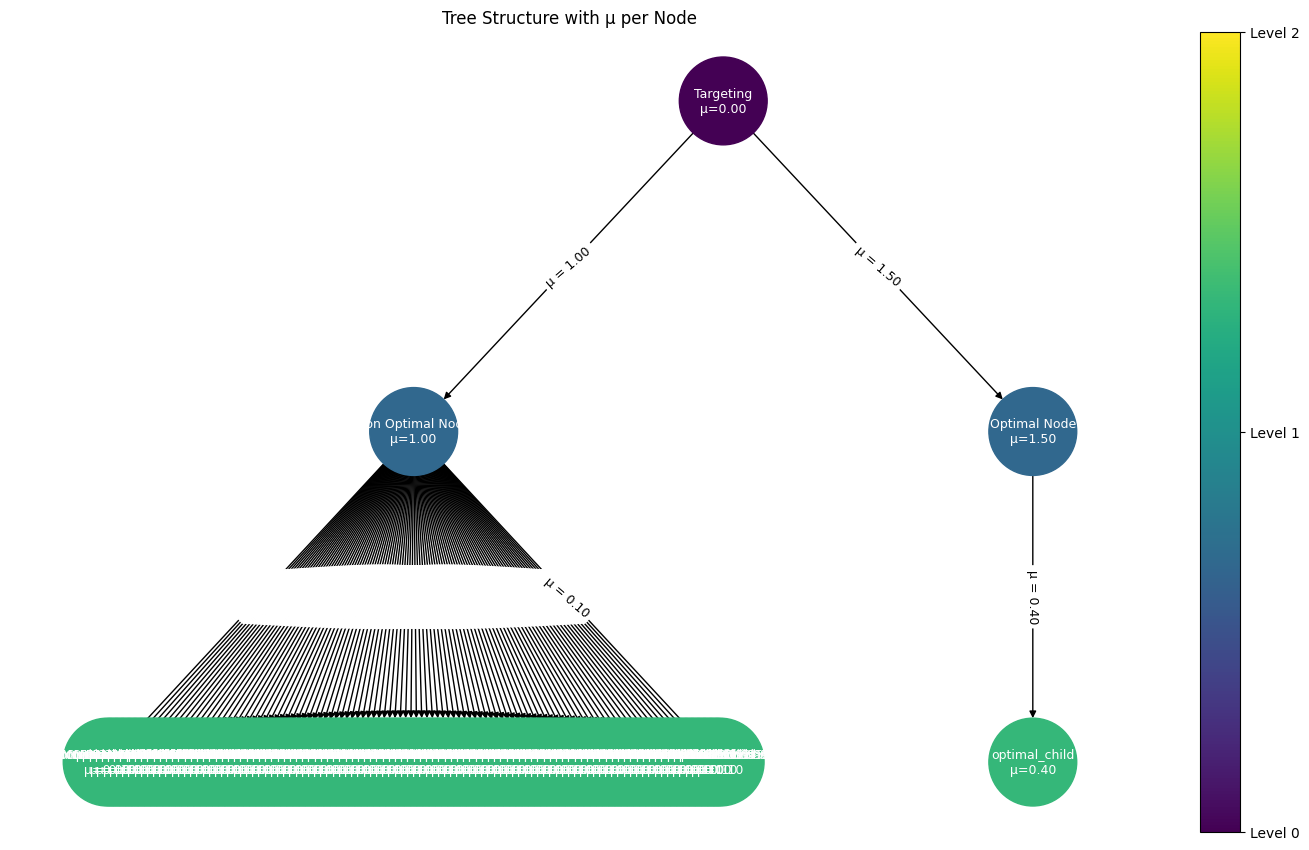

Best arm is optimal_child, the optimal path is then ['Targeting', 'Optimal Node', 'optimal_child'], and the corresponding reward is 1.9


100%|██████████| 10/10 [18:57<00:00, 113.79s/it]
/Users/a.cablant/Documents/GitHub/CRITEO-INTERNSHIP/src/utils/experiment.py:151: RuntimeWarning: divide by zero encountered in log
  UCB_regret = [np.sqrt(K * t * np.log(t)) for t in time_interval]
/Users/a.cablant/Documents/GitHub/CRITEO-INTERNSHIP/src/utils/experiment.py:151: RuntimeWarning: invalid value encountered in scalar multiply
  UCB_regret = [np.sqrt(K * t * np.log(t)) for t in time_interval]
/Users/a.cablant/Documents/GitHub/CRITEO-INTERNSHIP/src/utils/experiment.py:160: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


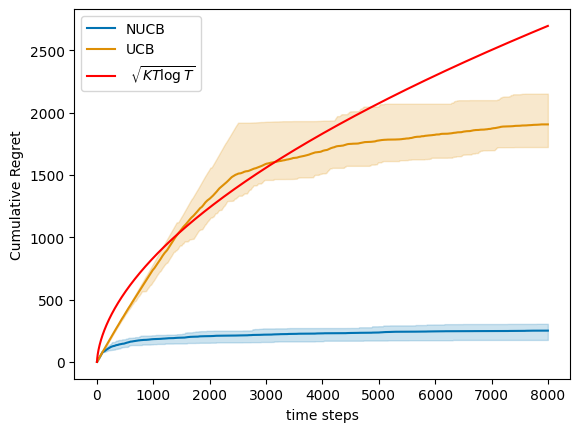

In [5]:
mus = [
    0, #root
    [1.0, 1.5],
    [[0.1]*100, [0.4]]
    ]

var = 1

T = 8000  # Finite Horizon
N = 10  # Monte Carlo simulations
q = 5  #choice of percentile display


for var in [1]:
    # Framework for the experiments
    env = StochasticEnvironmentExample(mus, var=var, patho=True)
    env.tree.visualize_tree_mu()
    action_set = env.get_action_set()

    # Initialization of the agents
    ucb = UCB(action_set=action_set)
    nucb = NUCB(tree=env.tree)
    #etc = ExploreThenCommit(action_set=action_set)

    # Run experiments
    all_data = experiment(env, [nucb, ucb], Nmc=N, T=T) # [etc, ucb, nucb]

    # Plot results
    plot_regret(regrets = all_data, logscale = False, lb = None, q = 0.5, UCB_regret=True)

In [4]:
mus_layer2 = mus[2]
mus_layer22 = mus_layer2[1]
mus_layer22

[0.4]

In [ ]:
T = 1000  # Finite Horizon
N = 50  # Monte Carlo simulations
q = 10  #choice of percentile display


# Framework for the experiments
env = StochasticEnvironment(layers=3, min_children=1, max_children=4, p=0.1, reward_min=0.3, reward_max=2.6, var=1, seed=2025)
env.tree.visualize_tree_mu()
action_set = env.get_action_set()

# Initialization of the agents
ucb = UCB(action_set=action_set)
nucb = NUCB(tree=env.tree)
#etc = ExploreThenCommit(action_set=action_set)

# Run experiments
for layer in [3, 4, 5, 6]:
    print("Layer:", layer)
    env = StochasticEnvironment(layers=layer, min_children=1, max_children=4, p=0.1, reward_min=0.3, reward_max=2.6, var=1, seed=2025)
    all_data = experiment(env, [ucb, nucb], Nmc=N, T=T)

    # Plot results
    plot_regret(regrets = all_data, logscale = False, lb = None, q = 0.5)